In [2]:
import numpy as np, arviz as az, matplotlib.pyplot as plt
import pystan, os, pygtc, pickle
from astropy.table import Table
from tabulate import tabulate     ## optional
from scipy.special import erf
from scipy.stats import norm, gaussian_kde
os.environ['STAN_NUM_THREADS'] = "2"  ## each chain uses 1 thread

### The Intrinsic Model

$$ \large
P(x) = \frac{A}{2}\mathcal{N}(x_0, \sigma_p)[1 + \mathrm{Erf}(\frac{x-x_0}{\sqrt{2}\sigma_{int}})] + F
$$


### The Convolved Model
$$ \large
\mathcal{L}_i(x_i) = \frac{A}{2}\mathcal{N}(x_0, \sigma_p)[1 + \mathrm{Erf}(\frac{x_i-x_0}{\sqrt{2}\Sigma_i})] + F
$$

#### Data set is:

$\large x_i$, the u-g color of each star;

$\large \sigma_i$, the measurement uncertainties on u-g color.

#### Free Parameters are: 

$\large x_0$, the edge u-g color of MSTO; 

$\large \sigma_{int}$, the intrinsic width of the edge;

$\large \sigma_p$, the width of MSTO u-g distribution.

#### Transformed Parameters are: 

$\large \Sigma_i^2 = \sigma_{int}^2 + \sigma_i^2$ is the effective width;

$\large F$ is the floor probability DENSITY, set by the fraction of stars bluer than $\large x_0$;

$\large A$ is the normalization factor of the Gaussian, which is determined by:

$$ \large
\int_a^b P(x)\mathrm{d}x= 1,
$$

or (assuming $\large \sigma_{int}$ is small), 

$$ \large
A = \frac{2(1-F(b-a))}{\mathrm{Erf}(\frac{b-x_0}{\sqrt{2}\sigma_p})}.
$$






### defining the model with fixed F

In [3]:
model = """
data {
  int J;                         // number of stars 
  real F;                        // probability density of stars bluer than edge
  real a;                        // lower limit of integral over u-g
  real b;                        // upper limit of integral over u-g
  vector[J] x;                   // u-g color of stars in the field
  vector[J] sigma;               // measurement uncertainties
}

parameters {
  real <lower=0.6, upper=1.1> x0;           // u-g color of the edge
  real <lower=0, upper=0.1> sigma_int;      // intrinsic scatter of edge
  real <lower=0, upper=1.0> sigma_p;        // width of the peak distribution
}

transformed parameters {
  real A;                                   // normalization factor
  vector[J] eff_sigma;                      // effective scatter
  
  eff_sigma = sqrt(square(sigma) + square(sigma_int));
  A = 2*(1 - F*(b-a))/erf( (b-x0)/(sqrt2()*sigma_p) );
}

model {
  vector[J] p1 = A*exp(-square(x-x0) / (2*square(sigma_p)) )  / (sqrt(2*pi())*sigma_p);
  vector[J] p2 = 0.5 + 0.5*erf( (x-x0) ./ (sqrt2()*eff_sigma) ); 
  target += log(p1 .* p2 + F);
} """

### defining the model (for plotting purpose only)

In [4]:
def int_pdf(x, x0, sigma_int, sigma_p, F, A):

    p1 = A*norm.pdf(x, loc=x0, scale=sigma_p)
    p2 = (1 + erf( (x-x0) / (np.sqrt(2) * sigma_int) ) ) / 2
    
    return p1*p2 + F

def conv_pdf(x, sigma, x0, sigma_int, sigma_p, F, A):

    eff_sigma = np.sqrt(sigma**2 + sigma_int**2)
    p1 = A*norm.pdf(x, loc=x0, scale=sigma_p)
    p2 = (1 + erf( (x-x0) / (np.sqrt(2) * eff_sigma) ) ) / 2
    
    return p1*p2 + F

### reading data

In [5]:
input = './test_DECam.fits'

### u-g preselection; Table 3 in paper ####
a = 0.5
b = 2.0

data = Table.read(input, format='fits')

ind, = np.where( (data['gmag'] > 18.5) & (data['gmag'] < 21) & (data['uerr'] < 0.1) & (data['gerr'] < 0.1) \
                & (data['umag'] - data['gmag'] > a) & (data['umag'] - data['gmag'] < b) )
data = data[ind]

x = data['umag'] - data['gmag']
sigma = np.sqrt( data['uerr']**2 + data['gerr']**2)

## sort x and sort sigma according to x
ind_sort = x.argsort()
x = x[ind_sort]
sigma = sigma[ind_sort]

### Floor interval for DECam is 0.5-0.8; Table 3 in paper ###
J = len(x)
F = np.sum( x < 0.8 ) / (0.8-a) / J

data_set = {'J':J, 'F':F, 'a':a, 'b':b, 'x':x, 'sigma':sigma}



### compile the stan C++ program

In [6]:
if 0: ## compile the model; needs only to do once
    
    extra_compile_args = ['-pthread', '-DSTAN_THREADS']
    sm = pystan.StanModel(model_code=model, extra_compile_args=extra_compile_args)
    
    with open('edge_model.pkl', 'wb') as f:
        pickle.dump(sm, f)

else:
    
    sm = pickle.load(open('edge_model.pkl', 'rb'))

### run the sampler

In [8]:
# each dictionary for a chain
# guess = [{'D':0.5, 'C':0.5, 'simga_int':0.01}, {'D':0.6, 'C':0.6, 'simga_int':0.02}, 
#         {'D':0.7, 'C':0.7, 'simga_int':0.03}, {'D':0.8, 'C':0.8, 'simga_int':0.04}]

if 0: ## run the sampler, save the chains
    
    guess = 'random'
    fit = sm.sampling(data=data_set, init=guess, iter=2000, chains=6, n_jobs=12)

    post = fit.extract()

    var_names = ['x0', 'sigma_int', 'sigma_p', 'A']
    var_dict = {var:post[var] for var in var_names}

    chains = np.transpose(np.array([var_dict[var] for var in var_names]))
    np.savetxt('test_DECam.chains', chains)
    
    print(fit.stansummary(pars=['x0', 'sigma_int', 'sigma_p', 'A'], digits_summary=4))
    
    az.plot_trace(fit, var_names=['x0', 'sigma_int', 'sigma_p', 'A'], \
                  chain_prop='color', compact_prop={"ls":":", 'lw':[1]*4})
    
else:
    
    chains = np.loadtxt('test_DECam.chains')
    
    var_names = ['x0', 'sigma_int', 'sigma_p', 'A']
    var_dict = {var:chains[:,i] for i,var in enumerate(var_names)}
    
    digits = 4
    var_16 = {var: np.round(np.percentile(var_dict[var],16), decimals=digits) for var in var_names}
    var_50 = {var: np.round(np.percentile(var_dict[var],50), decimals=digits) for var in var_names}
    var_84 = {var: np.round(np.percentile(var_dict[var],84), decimals=digits) for var in var_names}

    res_table = [[var, var_50[var], var_50[var] - var_16[var], var_84[var] - var_50[var] ] for var in var_names]

    print( tabulate(res_table, headers = ['Parameters', 'Values', 'Error_low', 'Error_high']) )

Parameters      Values    Error_low    Error_high
------------  --------  -----------  ------------
x0              0.9374       0.0033        0.0032
sigma_int       0.0198       0.0038        0.0037
sigma_p         0.5389       0.0141        0.0148
A               1.9446       0.0114        0.0127


 ### triangle plot using pygtc

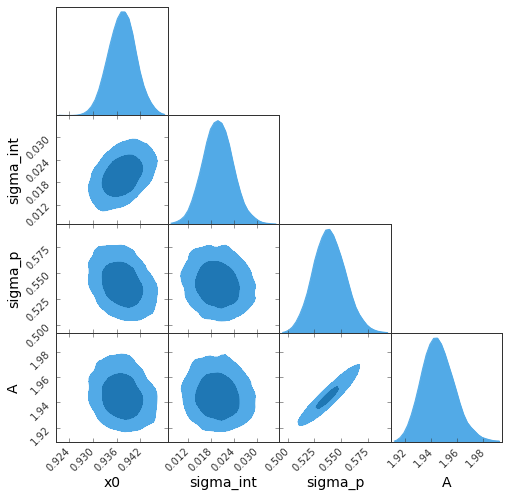

In [9]:
fig = pygtc.plotGTC(chains = chains, 
                   #chainLabels = ['North and South'],
                   paramNames = var_names,
                   #paramRanges = [(0.045, 0.105), (0.76, 0.82), (0.008,0.018)],
                   customTickFont = {'size':10},
                   customLabelFont = {'size':14},
                   customLegendFont = {'size':14},
                   colorsOrder = ['blues', 'oranges','purples'], 
                   # ['greens', 'reds',  'browns', 'pinks', 'grays', 'yellows', 'cyans']
                   figureSize=8)

### plot model

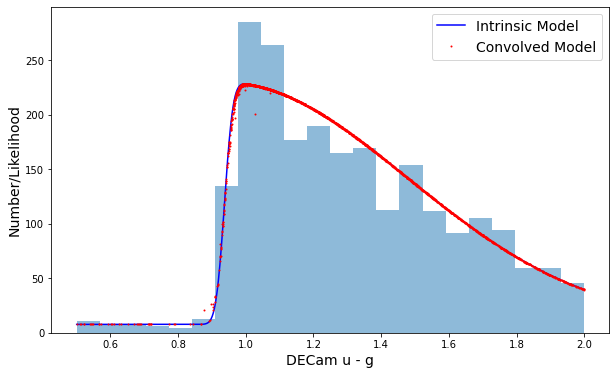

In [10]:
fig = plt.figure(figsize=(10, 6))
ax = plt.subplot(111)
ax.set_xlabel('DECam u - g', fontsize=14)
ax.set_ylabel('Number/Likelihood', fontsize=14)

x0, sigma_int, sigma_p, A = [var_50[var] for var in var_names]
x_grid = np.linspace(x.min(), x.max(), 1000)

n, bins, patches = ax.hist(x, bins='auto', alpha=0.5)

bin_width = bins[1] - bins[0]

S = len(x) * bin_width

ax.plot(x_grid, S*int_pdf(x_grid, x0, sigma_int, sigma_p, F, A),'b', label=r'Intrinsic Model')
ax.plot(x, S*conv_pdf(x, sigma, x0, sigma_int, sigma_p, F, A), 'r.', markersize=2, label=r'Convolved Model')

ax.legend(prop={'size': 14})

### summary statistics from the chains;
#### to find mode and 1$\sigma$ uncertainty from the 1d posterior distributions
#### works for non-gaussian or truncated posteriors too


In [11]:
def find_area(x_grid, pdf, pdf_roll, bar, peak_ind, bin_width):

    area = []
    diff_product = (pdf-bar) * (pdf_roll-bar)
    cross_id, = np.where( diff_product < 0 )

    left_ids = cross_id[ cross_id <= peak_ind ]
    right_ids = cross_id[ cross_id > peak_ind ]

    if np.sum( left_ids ) == 0:
        left_ids = [0]                         ## open pdf on the left; parameter hitting lower limit

    if np.sum( right_ids ) == 0:
        right_ids = [len(pdf) - 2]             ## open pdf on the right; parameter hitting higher limit

    for l_id in left_ids:
        for r_id in right_ids:

            area.append( {'x_left':x_grid[l_id], 'x_right':x_grid[r_id], \
                'dp_left':(pdf[l_id+1]-pdf[l_id])/bin_width, 'dp_right':(pdf[r_id+1]-pdf[r_id])/bin_width, \
                'area':np.sum( pdf[l_id:r_id]) * bin_width} )

            if l_id == 0:
              area[-1]['dp_left'] = np.inf

            if r_id == len(pdf) - 2:
              area[-1]['dp_right'] = -np.inf

    return area

def find_mode(x_grid, pdf, pdf_roll, bar_t, bar_b, layer='0'):

    peak_ind, = np.where( pdf == pdf.max())
    x_best = x_grid[peak_ind[0]]

    bin_width = x_grid[1] - x_grid[0]
    sig1 = 0.6827               ## 1-sigma area
    eps_answ = 1e-3
    eps_stop = 1e-4

    bar = (bar_t + bar_b) / 2

    ## search for bar-crossing, calculate area in-between
    area = find_area(x_grid, pdf, pdf_roll, bar, peak_ind, bin_width)
    
    print('branch on the tree:', layer)
    print('bar height:', bar)
    print('area in between:', area)
    print('')

    move_up = False
    move_dn = False

    found_in_up = False
    found_in_dn = False

    for A in area:

        if (np.abs(A['area'] - sig1) < eps_answ):
            print('Eureka!', layer, A)
            return [x_best, A['x_left'], A['x_right'], True]

        else:
            if (A['area'] > sig1):   ## want to decrease area

                if (A['dp_left'] > 0) and (A['dp_right'] < 0):
                    move_up = move_up or True

                elif (A['dp_left'] < 0) and (A['dp_right'] > 0):
                    move_dn = move_dn or True

                elif (A['dp_left'] < 0) and (A['dp_right'] < 0):
                    move_up = move_up or (np.abs(A['dp_left']) > np.abs(A['dp_right']))
                    move_dn = move_dn or (np.abs(A['dp_left']) < np.abs(A['dp_right']))

                elif (A['dp_left'] > 0) and (A['dp_right'] > 0):
                    move_up = move_up or (np.abs(A['dp_left']) < np.abs(A['dp_right']))
                    move_dn = move_dn or (np.abs(A['dp_left']) > np.abs(A['dp_right']))

            else:                   ## want to increase area

                if (A['dp_left'] > 0) and (A['dp_right'] < 0):
                    move_dn = move_dn or True

                elif (A['dp_left'] < 0) and (A['dp_right'] > 0):
                    move_up = move_up or True

                elif (A['dp_left'] < 0) and (A['dp_right'] < 0):
                    move_up = move_up or (np.abs(A['dp_left']) < np.abs(A['dp_right']))
                    move_dn = move_dn or (np.abs(A['dp_left']) > np.abs(A['dp_right']))

                elif (A['dp_left'] > 0) and (A['dp_right'] > 0):
                    move_up = move_up or (np.abs(A['dp_left']) > np.abs(A['dp_right']))
                    move_dn = move_dn or (np.abs(A['dp_left']) < np.abs(A['dp_right']))

    ## dead-end; hope is at other branch(es)
    if (bar_t - bar < eps_stop) or (bar - bar_b < eps_stop):
        print('Dead End!')
        return [-1,-1,-1,False]

    if move_up:
        layer += 'u'
        x_best_up, x_low_up, x_high_up, found_in_up = find_mode(x_grid, pdf, pdf_roll, bar_t, bar, layer=layer)
        if found_in_up:
            return [x_best, x_low_up, x_high_up, True]

    if move_dn:
        layer += 'd'
        x_best_dn, x_low_dn, x_high_dn, found_in_dn = find_mode(x_grid, pdf, pdf_roll, bar, bar_b, layer=layer)
        if found_in_dn:
            return [x_best, x_low_dn, x_high_dn, True]

    if ~(move_up or move_dn):
        print('not moving?')
        return [-1,-1,-1,False]

    return [-1,-1,-1,False]

In [12]:
chains = np.loadtxt('test_DECam.chains')
x = chains[:,1]   ## x is x_0
x_grid = np.linspace(x.min(), x.max(), 30000)

In [13]:
kde = gaussian_kde(x)
pdf = kde.evaluate(x_grid)

In [14]:
## shift the elements by 1 index; used to find roots of bar cross pdf
pdf_roll = np.roll(pdf, -1)

In [15]:
## find the mode value of posterios;
## remove the last element due to shifting
res = find_mode(x_grid[:-1], pdf[:-1], pdf_roll[:-1], pdf.max(), 0, layer='0')

branch on the tree: 0
bar height: 51.22182188189852
area in between: [{'x_left': 0.015247554550569295, 'x_right': 0.024224389780061507, 'dp_left': 14694.845969447411, 'dp_right': -18889.951594003225, 'area': 0.7624950956635762}]

branch on the tree: 0u
bar height: 76.83273282284779
area in between: [{'x_left': 0.016738362517631063, 'x_right': 0.022905150740288385, 'dp_left': 22302.69002036055, 'dp_right': -16859.338657718683, 'area': 0.5837837665049119}]

branch on the tree: 0ud
bar height: 64.02727735237315
area in between: [{'x_left': 0.01608795149949163, 'x_right': 0.023581733289709132, 'dp_left': 16698.244295050477, 'dp_right': -20334.595798231898, 'area': 0.677178122306243}]

branch on the tree: 0udd
bar height: 57.624549617135834
area in between: [{'x_left': 0.015677930842750973, 'x_right': 0.023896760981058335, 'dp_left': 15009.070943896253, 'dp_right': -20119.463222144303, 'area': 0.7212563566073338}]

branch on the tree: 0uddu
bar height: 60.825913484754494
area in between: [{

In [16]:
## res = [x_best, x_left, x_right, finish_flag]
print(res)

[0.019783953305997817, 0.016039485700822524, 0.0236214752446178, True]


/home/cool/miniconda3/envs/pystan/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


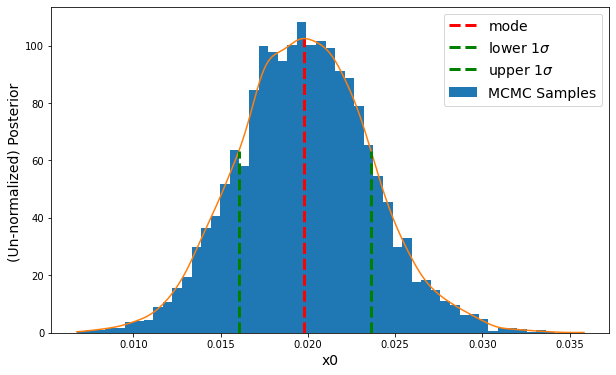

In [17]:
fig = plt.figure(figsize=(10, 6))
ax = plt.subplot(111)

ax.hist(x, bins='auto', density=True, label='MCMC Samples')
ax.set_xlabel('x0', fontsize=14)
ax.set_ylabel('(Un-normalized) Posterior ', fontsize=14)

ax.plot(x_grid, pdf)
ax.plot([res[0]]*2, [0,  kde.evaluate(res[0])], 'r--', lw=3, label='mode')
ax.plot([res[1]]*2, [0,  kde.evaluate(res[1])], 'g--', lw=3, label=r'lower 1$\sigma$')
ax.plot([res[2]]*2, [0,  kde.evaluate(res[2])], 'g--', lw=3, label=r'upper 1$\sigma$')

ax.legend(prop={'size':14})